In [58]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import tensorflow
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import os

In [59]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [60]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [61]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [62]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [63]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [64]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [65]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535,
 'LatOcc': 928}

In [66]:
# Data cleanup

remove_indices = np.empty(0, dtype=int)

remove_indices = np.append(remove_indices, np.where(labels[0, :] == 'person')[0])

remove_indices = np.append(remove_indices, np.where(labels[0, :] == 'fungus')[0])

remove_indices = np.append(remove_indices,  np.where(labels[0, :] == 'plant')[0])

remove_indices = np.append(remove_indices, np.where(labels[1, :] == 'instrumentality')[0])

#Remove the data
dat["stimuli"] = np.delete(dat["stimuli"], remove_indices, axis=0)

dat["responses"] = np.delete(dat["responses"], remove_indices, axis=0)

labels = np.delete(labels, remove_indices, axis=1)

print(dat["stimuli"].shape)
print(dat["responses"].shape)



(1390, 128, 128)
(1390, 8428)


Each stimulus is a 128 x 128 grayscale array:

C:\Users\mikke\AppData\Local\Temp\ipykernel_37328\24014900.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


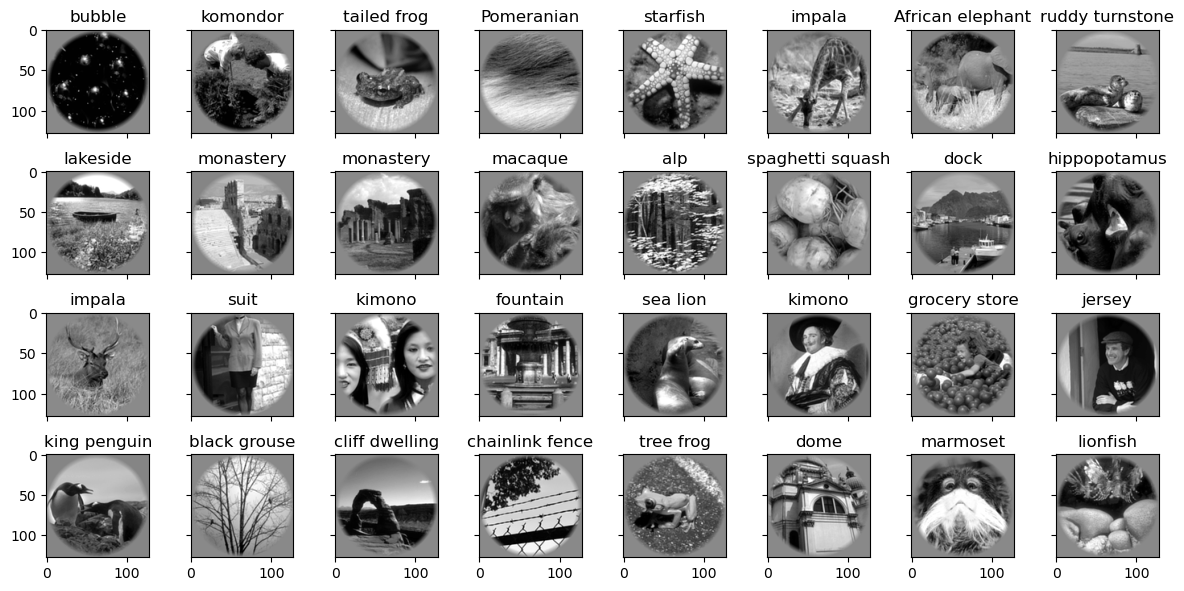

In [67]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\mikke\AppData\Local\Temp\ipykernel_37328\2625672689.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


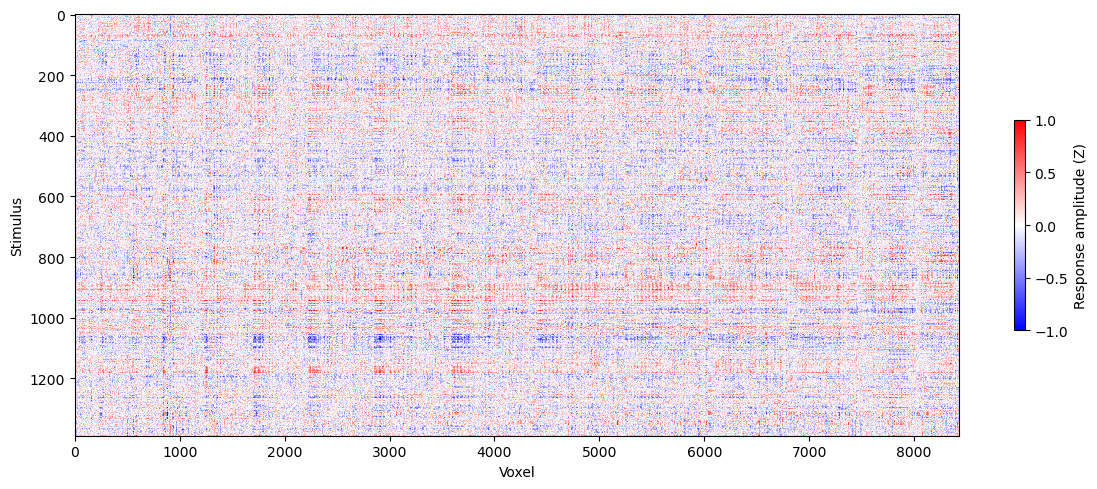

In [68]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

C:\Users\mikke\AppData\Local\Temp\ipykernel_37328\1498469230.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


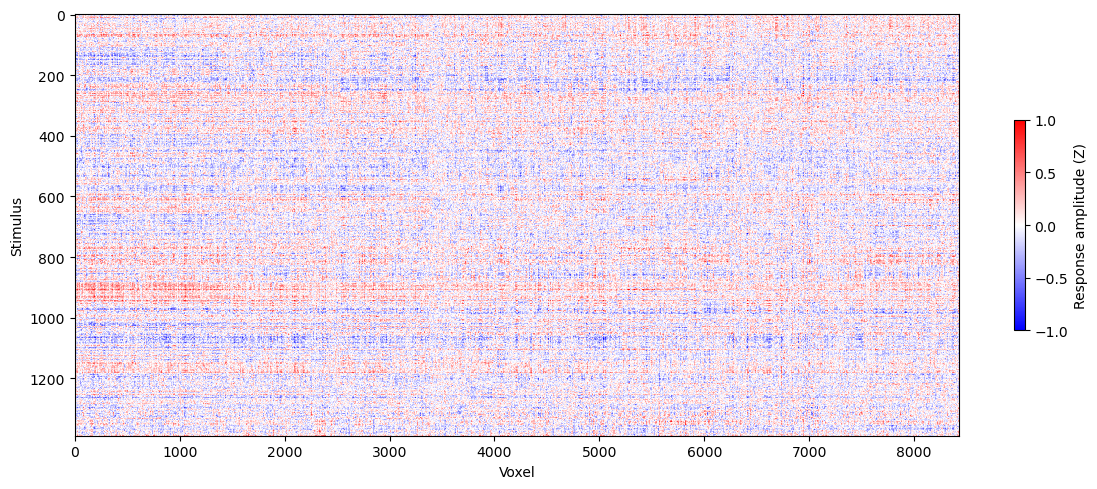

In [69]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [70]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [dat['responses'][labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

Unique categories: ['animal' 'artifact' 'entity' 'fruit' 'geological formation']
Category animal has shape (589, 8428)
Category artifact has shape (462, 8428)
Category entity has shape (72, 8428)
Category fruit has shape (77, 8428)
Category geological formation has shape (190, 8428)


C:\Users\mikke\AppData\Local\Temp\ipykernel_37328\1454581728.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


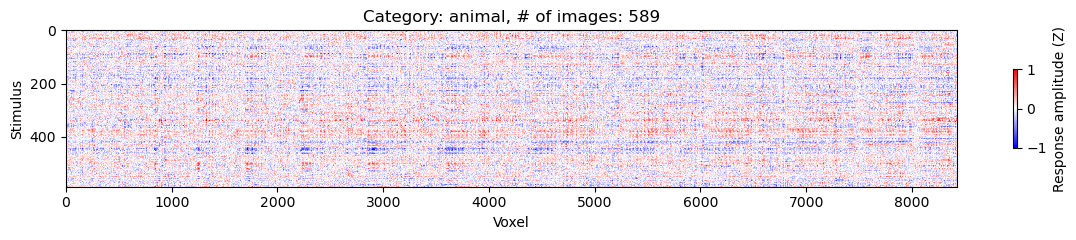

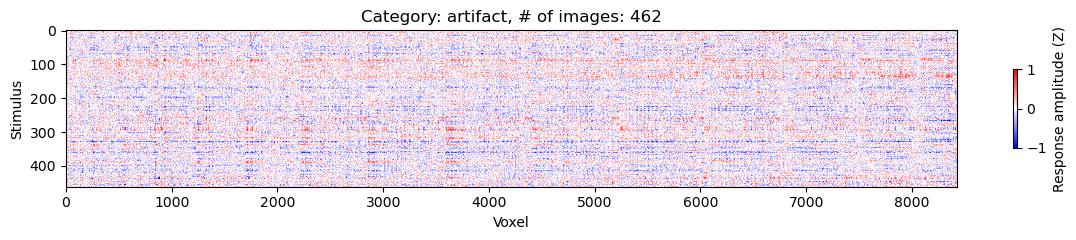

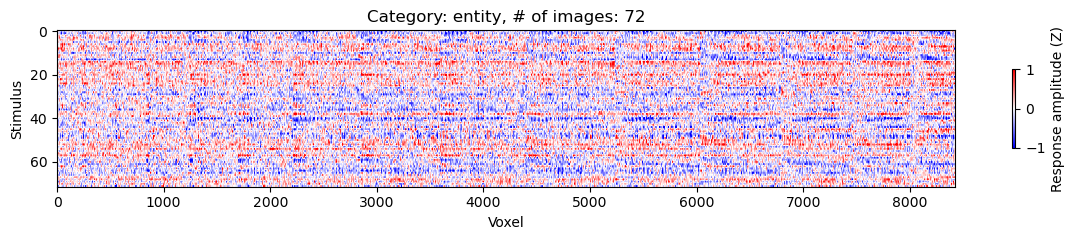

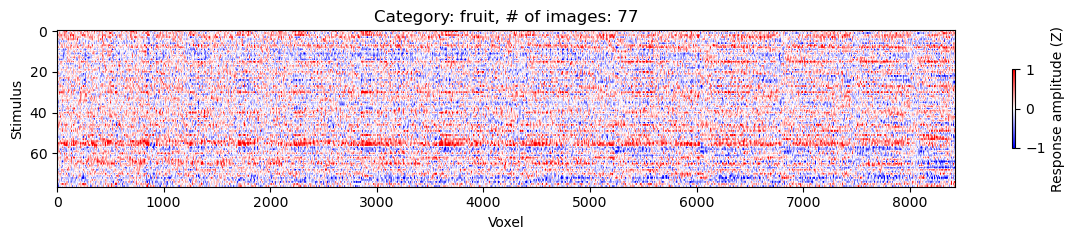

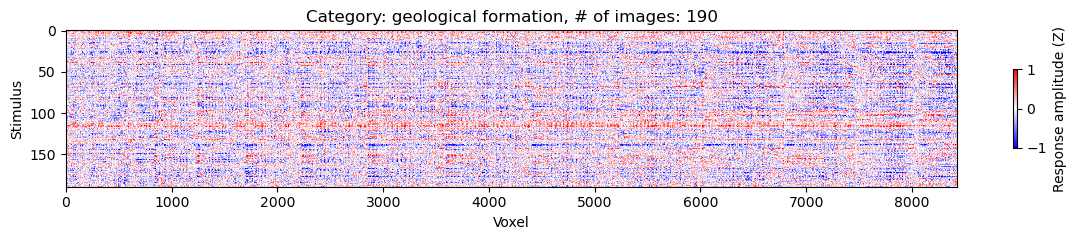

In [71]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

In [72]:
# Visualize fMRI on brain map


C:\Users\mikke\AppData\Local\Temp\ipykernel_37328\3850067406.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


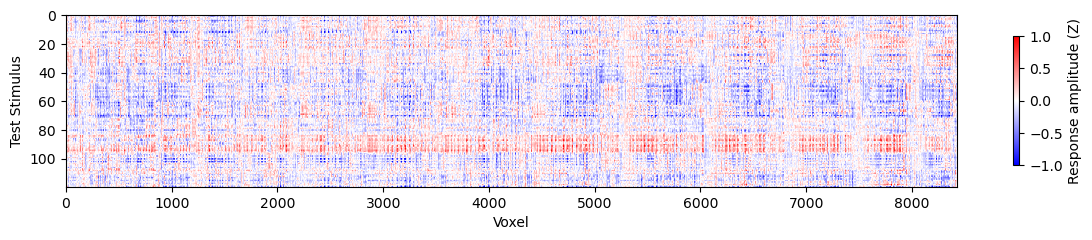

In [73]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Visualization of the means for the ROIs, compared across different stimuli of the same category

In [74]:
# Functions for plotting barplots of the different ROI's means for a specific category

def compute_roi_bins(image_index):
    responses = dat["responses"]
    rois = dat["roi"]
    roi_names_count = np.bincount(rois)[1:]

    roi_bins = [0, 0, 0, 0, 0, 0, 0]
    # For one image, go through all voxels recorded
    for i in range(len(responses[0])):
        roi_index = rois[i] - 1
        roi_bins[roi_index] += responses[image_index][i]
    for i in range(len(roi_bins)):
        roi_bins[i] /= roi_names_count[i]
    
    return roi_bins

def compute_roi_distributions_from_category(category, category_hierarchy, count):
    index = 0
    graphs_xvalues = []
    graphs_specific_labels = []
    while len(graphs_xvalues) < count:
        #print(labels[category_hierarchy][index], '/', category)
        if labels[category_hierarchy][index] == category: # category hierachy level
            graphs_xvalues.append(compute_roi_bins(index))
            graphs_specific_labels.append(labels[3][index])
        index += 1

    return graphs_xvalues, graphs_specific_labels

def barplot_roi_distribution(category, graph_xvalues, graph_specific_labels, ylim=[-0.4, 0.4], plot_rows=3, plot_cols=4):
    figure, axis = plt.subplots(plot_rows, plot_cols, figsize=(12,8))
    figure.suptitle(category)
    for ax, im, lbl in zip(axis.flat, graph_xvalues, graph_specific_labels):
        ax.set_ylim(ylim)
        ax.bar(range(len(im)), im)
        ax.set_title(lbl)
    figure.tight_layout()
    figure.show()

In [75]:
# Plot barplots of ROI distribution for a specified category
# Specify category name, it's hierarchy level, and how many stimili there is
category_name = 'tree frog'
category_hierarchy = 3
count = 6
roi_distributions_values, roi_distibutions_labels = compute_roi_distributions_from_category(category_name, category_hierarchy, count)
barplot_roi_distribution(category_name, roi_distributions_values, roi_distibutions_labels)

IndexError: index 1390 is out of bounds for axis 0 with size 1390

C:\Users\mikke\AppData\Local\Temp\ipykernel_37328\119951743.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


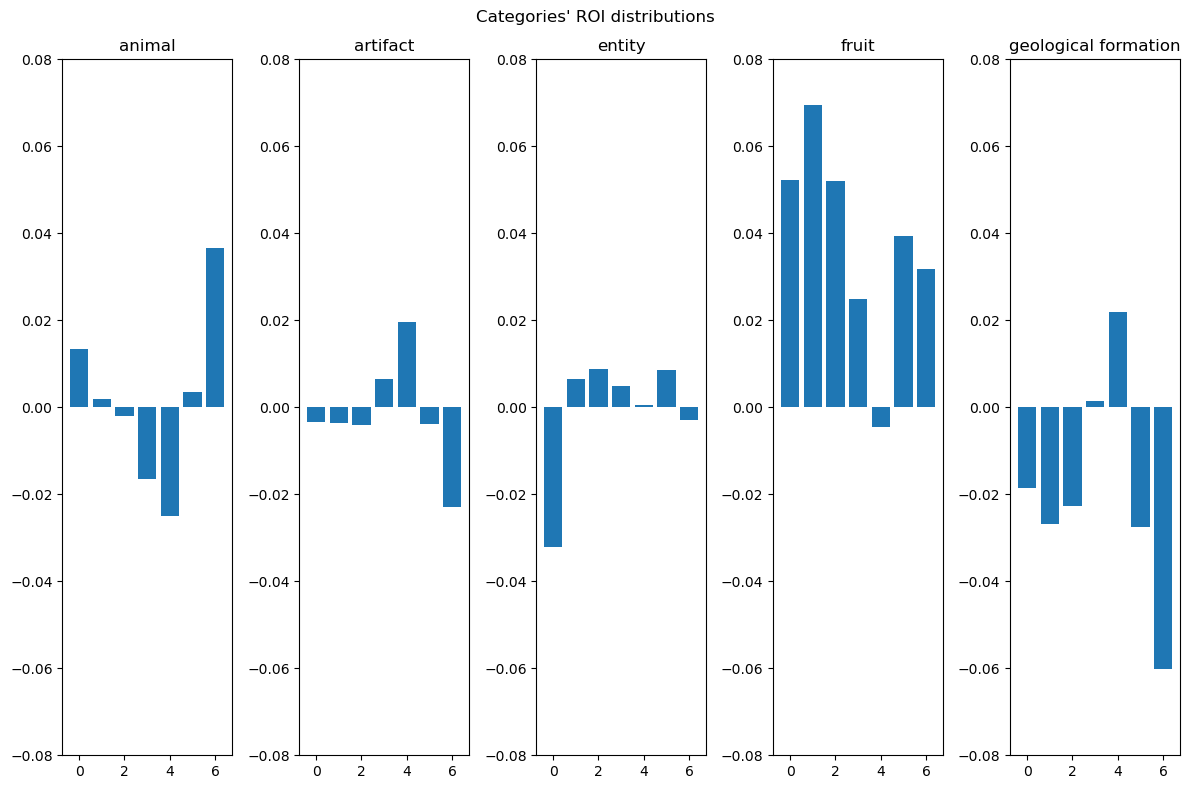

In [76]:
# Plot ROI distributions' means over all categories
# (Hardcoded to only work on category hierarchy 0 for now)

unique_labels = np.unique(labels[0, :])
# Lists to store values
total_roi_values = np.zeros((len(unique_labels), len(dat['roi_names']) - 1))
# (I didn't know how to get the sample count for each category?)
category_counts = [589, 462, 72, 77, 190]

# Loop to go through each sample 
for i in range(len(labels[0])):
    # Loop to go through each unique label (category)
    for label in range(len(unique_labels)):
        # Assign computed ROI distribution to total ROI value list in correct index (hence the previous loop)
        if labels[0][i] == unique_labels[label]:
            total_roi_values[label] += compute_roi_bins(i)

# Loop to update total ROI value list to means
for label in range(len(total_roi_values)):
    total_roi_values[label] /= category_counts[label]

barplot_roi_distribution("Categories' ROI distributions", total_roi_values, unique_labels, ylim=[-0.08, 0.08], plot_rows=1, plot_cols=5)

### Reducing output size to number of ROI's instead of voxels

In [77]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
roi_count_dict = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

output_reduced_to_ROIs = np.zeros((1390, 7))
for sample in range(len(output_reduced_to_ROIs)):
    oldValue = 0
    count = 0
    for key, value in roi_count_dict.items():
        if value > 0:
            response_values = sorted_responses[:, oldValue:oldValue+value]
            #print(response_values.shape)
            summed_roi = np.mean(response_values[sample])
            output_reduced_to_ROIs[sample][count] = summed_roi
            count += 1
        oldValue = value

print(output_reduced_to_ROIs.shape)
print(output_reduced_to_ROIs[1])

(1390, 7)
[0.05721053 0.07615039 0.03697864 0.10050101 0.05378201 0.06976957
 0.11060242]


# Encoder model

In [78]:
# CNN model for voxel-wise encoding
class EncoderModel(nn.Module):
    def __init__(self, dimension_length, num_outputs):
        super(EncoderModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=32, out_features=num_outputs)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images

        x = self.features(x)
        x = self.classifier(x)

        return x

In [89]:
class Encoder():
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.losses = []
        self.best_loss = 1000000
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training data and labels
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = EncoderModel(x_train_tensor.shape[1], self.output.shape[1])
        
        # MSELoss instead of CrossEntropy beause it is more of a regression problem than classification
        criterion = nn.MSELoss()

        # Optimizer
        optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True)

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()

            #if i % 100 == 0 and i != 0:
            #    print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, train_running_loss / 100))
            #    train_running_loss = 0.0
            
        return last_loss


    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            if train_running_loss < self.best_loss:
                self.best_loss = train_running_loss
                best_model = encoder_model.state_dict()

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format(epoch, train_running_loss))
        
            if (epoch+1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title("Encoder Loss")
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                # Save plot in png file if wanted
                #plt.savefig(f'loss_plotepoch{epoch+1}.png')
                plt.show()
        
        torch.save(best_model, os.path.join('./trained_models/', 'trainedmodel_best_epoch_{}.pth'.format(epoch)))

        return encoder_model

Original input data shape: (1390, 128, 128)
Reshaped 4D input data shape: (1390, 128, 128, 1)
(1390, 7)
Epoch: 0 | Loss: 0.05386102572083473
Epoch: 1 | Loss: 0.041447967290878296
Epoch: 2 | Loss: 0.058086223900318146
Epoch: 3 | Loss: 0.0567740723490715
Epoch: 4 | Loss: 0.03807072341442108
Epoch: 5 | Loss: 0.05645899474620819
Epoch: 6 | Loss: 0.058296654373407364
Epoch: 7 | Loss: 0.049437496811151505
Epoch: 8 | Loss: 0.038306303322315216
Epoch: 9 | Loss: 0.06714273989200592


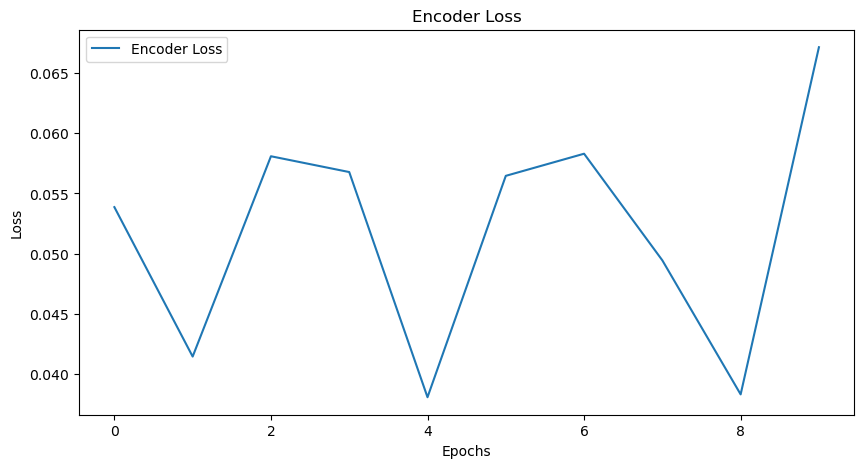

Epoch: 10 | Loss: 0.0651363804936409
Epoch: 11 | Loss: 0.09151255339384079
Epoch: 12 | Loss: 0.11288969218730927
Epoch: 13 | Loss: 0.04148478806018829
Epoch: 14 | Loss: 0.07783079892396927
Epoch: 15 | Loss: 0.06046513095498085
Epoch: 16 | Loss: 0.0706835687160492
Epoch: 17 | Loss: 0.06801542639732361
Epoch: 18 | Loss: 0.039904069155454636
Epoch: 19 | Loss: 0.060915473848581314


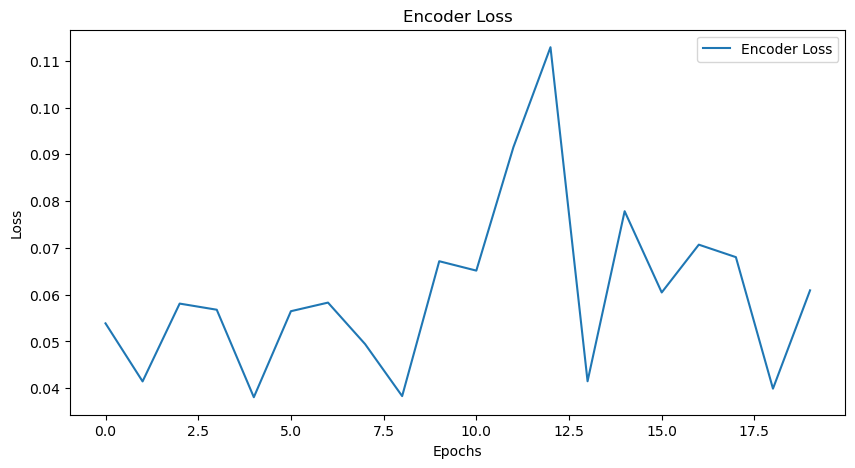

Epoch: 20 | Loss: 0.03847464546561241
Epoch: 21 | Loss: 0.06511640548706055
Epoch: 22 | Loss: 0.08802896738052368
Epoch: 23 | Loss: 0.03864722326397896
Epoch: 24 | Loss: 0.04407406225800514
Epoch: 25 | Loss: 0.040972091257572174
Epoch: 26 | Loss: 0.05840417370200157
Epoch: 27 | Loss: 0.04830872640013695
Epoch: 28 | Loss: 0.08537454903125763
Epoch: 29 | Loss: 0.0427384115755558


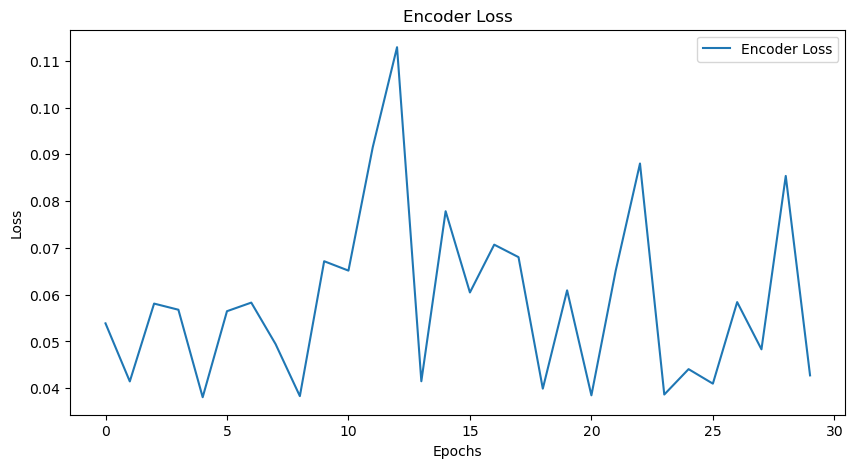

Epoch: 30 | Loss: 0.04431872442364693
Epoch: 31 | Loss: 0.04773484542965889
Epoch: 32 | Loss: 0.03390965238213539
Epoch: 33 | Loss: 0.061116959899663925
Epoch: 34 | Loss: 0.07430525869131088
Epoch: 35 | Loss: 0.055583368986845016
Epoch: 36 | Loss: 0.05187029764056206
Epoch: 37 | Loss: 0.0715375617146492
Epoch: 38 | Loss: 0.06594584882259369
Epoch: 39 | Loss: 0.06383395195007324


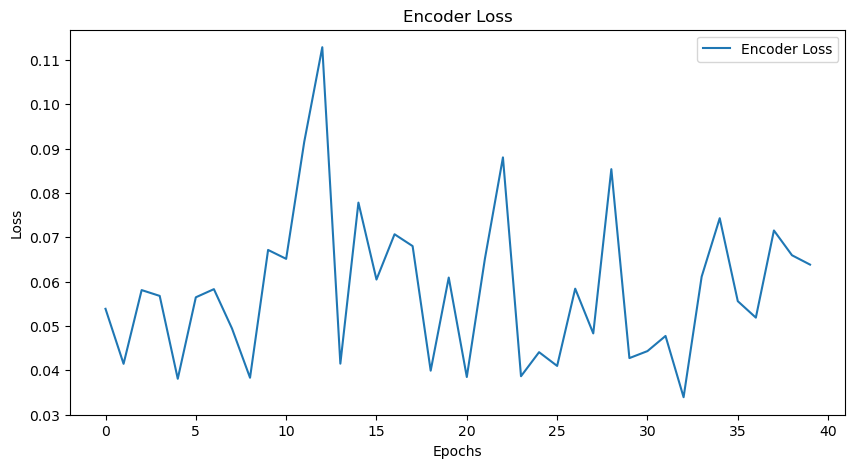

Epoch: 40 | Loss: 0.030352259054780006
Epoch: 41 | Loss: 0.0271354541182518
Epoch: 42 | Loss: 0.06491634994745255
Epoch: 43 | Loss: 0.03722622990608215
Epoch: 44 | Loss: 0.04620654135942459
Epoch: 45 | Loss: 0.05047016590833664
Epoch: 46 | Loss: 0.04783672094345093
Epoch: 47 | Loss: 0.061236169189214706
Epoch: 48 | Loss: 0.03956272080540657
Epoch: 49 | Loss: 0.07218801230192184


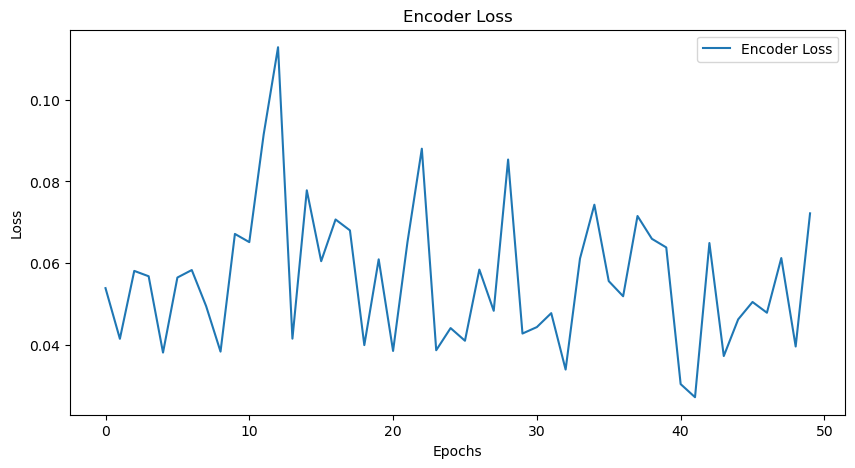

Epoch: 50 | Loss: 0.04578375816345215
Epoch: 51 | Loss: 0.08653417229652405
Epoch: 52 | Loss: 0.06508529186248779
Epoch: 53 | Loss: 0.04873150587081909
Epoch: 54 | Loss: 0.0556645430624485
Epoch: 55 | Loss: 0.08069721609354019
Epoch: 56 | Loss: 0.04586581140756607
Epoch: 57 | Loss: 0.03776140511035919
Epoch: 58 | Loss: 0.08640658110380173
Epoch: 59 | Loss: 0.04946807026863098


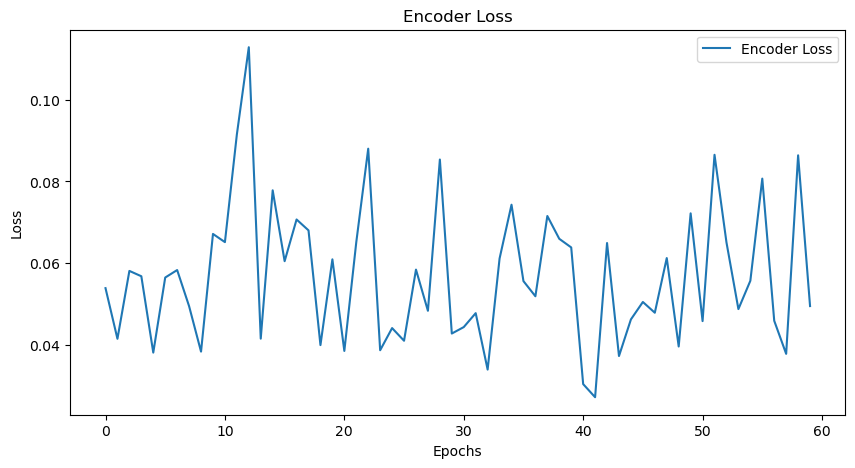

Epoch: 60 | Loss: 0.06877115368843079
Epoch: 61 | Loss: 0.04800920560956001
Epoch: 62 | Loss: 0.05311659723520279
Epoch: 63 | Loss: 0.07494443655014038
Epoch: 64 | Loss: 0.07127392292022705
Epoch: 65 | Loss: 0.04849652945995331
Epoch: 66 | Loss: 0.041945379227399826
Epoch: 67 | Loss: 0.0435861237347126
Epoch: 68 | Loss: 0.08400560170412064
Epoch: 69 | Loss: 0.051619675010442734


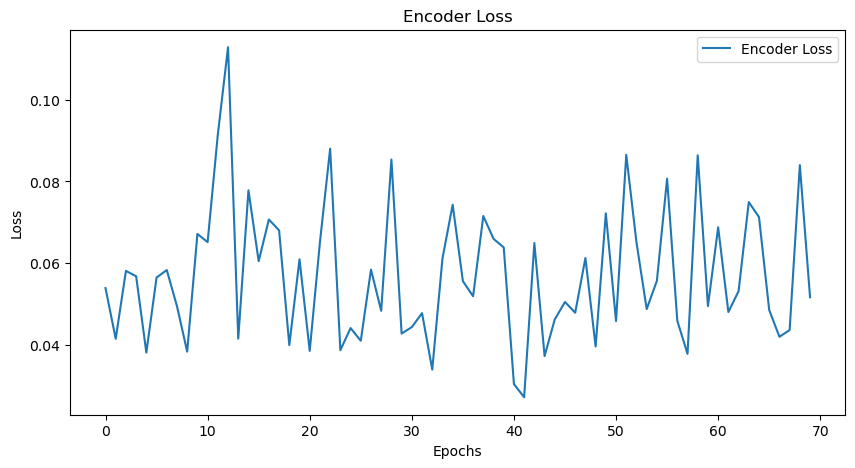

Epoch: 70 | Loss: 0.0661456286907196
Epoch: 71 | Loss: 0.080477774143219
Epoch: 72 | Loss: 0.04258760064840317
Epoch: 73 | Loss: 0.04469570890069008
Epoch: 74 | Loss: 0.06214343383908272
Epoch: 75 | Loss: 0.04703636094927788
Epoch: 76 | Loss: 0.0727827399969101
Epoch: 77 | Loss: 0.02119189314544201
Epoch: 78 | Loss: 0.049679458141326904
Epoch: 79 | Loss: 0.05095952749252319


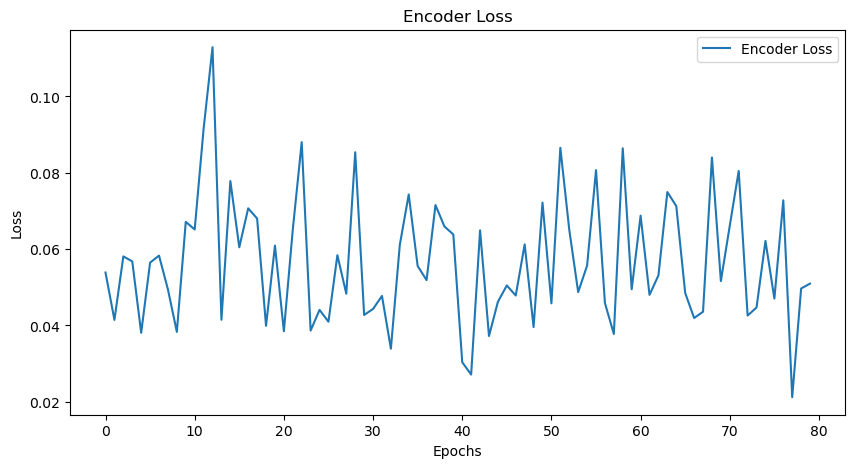

Epoch: 80 | Loss: 0.11124708503484726
Epoch: 81 | Loss: 0.025881245732307434
Epoch: 82 | Loss: 0.045173704624176025
Epoch: 83 | Loss: 0.058851514011621475
Epoch: 84 | Loss: 0.04683159664273262
Epoch: 85 | Loss: 0.03192995488643646
Epoch: 86 | Loss: 0.030476950109004974
Epoch: 87 | Loss: 0.05678468197584152
Epoch: 88 | Loss: 0.04476520046591759
Epoch: 89 | Loss: 0.035062581300735474


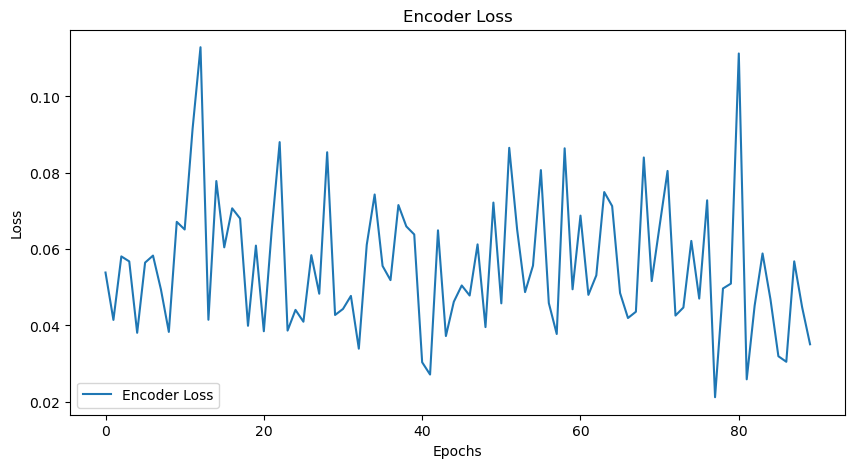

Epoch: 90 | Loss: 0.03306083381175995
Epoch: 91 | Loss: 0.054549235850572586
Epoch: 92 | Loss: 0.03782154247164726
Epoch: 93 | Loss: 0.03653278946876526
Epoch: 94 | Loss: 0.03936329483985901
Epoch: 95 | Loss: 0.0681585893034935
Epoch: 96 | Loss: 0.04831169545650482
Epoch: 97 | Loss: 0.07872083783149719
Epoch: 98 | Loss: 0.018741359934210777
Epoch: 99 | Loss: 0.1115952804684639


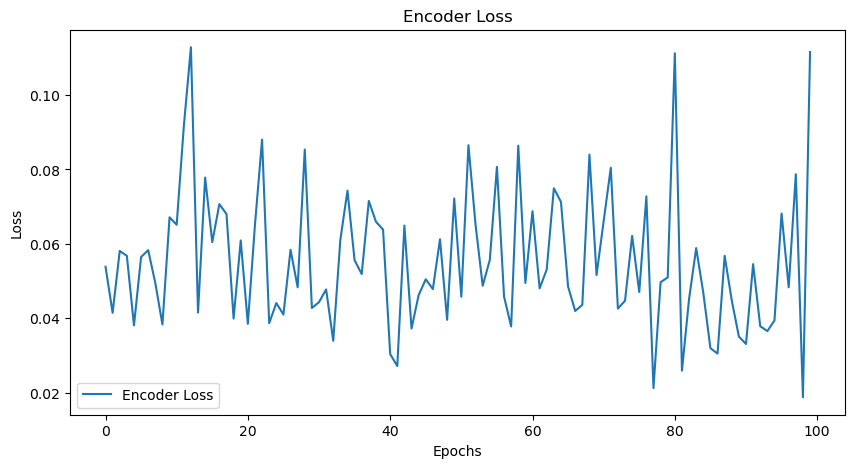

In [90]:
input = dat['stimuli']
print('Original input data shape:', input.shape)
fourD_input = np.reshape(input, (len(input), len(input[0]), len(input[1]), 1))
print('Reshaped 4D input data shape:', fourD_input.shape)

output = dat['responses']
output = output_reduced_to_ROIs # 7 instead of 8428

encoder = Encoder(input, output)
print(output.shape)
trained_model = encoder.train(batch_size=32, num_epochs=100)

# Testing model